# **Initialization**

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Number of GPUs:", torch.cuda.device_count())
print("Current/Main device:", torch.cuda.current_device())

for i in range(torch.cuda.device_count()):
    print("Device {}:".format(i), torch.cuda.get_device_name(i))

Number of GPUs: 1
Current/Main device: 0
Device 0: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install numba
!pip install annoy
!pip install pacmap
!pip install umap-learn
!pip install fastai

import pacmap

In [ ]:
import torch.distributed as dist
import os

def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

# **Architecture**

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import torch
from torch import nn

from torchvision import models

class Encoder(nn.Module):

    def __init__(self, base_encoder, strip_fc=True):
        super(Encoder, self).__init__()

        # create the encoder
        # num_classes is the output fc dimension
        self.arch = base_encoder
        built_encoder = models.__dict__[self.arch]
        self.encoder = built_encoder(pretrained=False)
            
        if strip_fc:
            if "vgg" in base_encoder:
                self.encoder.classifier = nn.Sequential(*list(self.encoder.classifier.children())[:-3])
            elif "densenet" in base_encoder:
                self.encoder.classifier = nn.Sequential(*list(self.encoder.classifier.children())[:-1])
            else:
                self.encoder = nn.Sequential(*list(self.encoder.children())[:-1])
        if base_encoder == "resnet18":
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                *list(self.encoder.children())[1:3],
                *list(self.encoder.children())[4:],
            )

    def forward(self, x):
        r = self.encoder(x)
        r_flat = torch.flatten(r, start_dim=1)
        return r_flat

In [ ]:
class Projector(nn.Module):

    def __init__(self, proj_dims):
        super(Projector, self).__init__()

        in_dim = proj_dims[0]
        h_dim = proj_dims[1]
        out_dim = proj_dims[2]

        self.projector = nn.Sequential(
            nn.Linear(in_dim, h_dim, bias=False),
            nn.BatchNorm1d(h_dim),
            nn.ReLU(inplace=True),  # first layer
            nn.Linear(h_dim, h_dim, bias=False),
            nn.BatchNorm1d(h_dim),
            nn.ReLU(inplace=True),  # second layer
            nn.Linear(h_dim, out_dim, bias=False), # third layer
            nn.BatchNorm1d(out_dim, affine=False),
        )
    
    def forward(self, x):
        z = self.projector(x)
        return z

In [ ]:
class Predictor(nn.Module):

    def __init__(self, pred_dims):
        super(Predictor, self).__init__()
        emb_dim = pred_dims[0]
        pred_dim = pred_dims[1]

        self.predictor = nn.Sequential(
            nn.Linear(emb_dim, pred_dim, bias=False),
            nn.BatchNorm1d(pred_dim),
            nn.ReLU(inplace=True),  # hidden layer
            nn.Linear(pred_dim, emb_dim),
        )  # output layer

    def forward(self, x):
        z = self.predictor(x)
        return z

In [ ]:
class SimSiamModel(nn.Module):

    def __init__(self, base_encoder, proj_dims, pred_dims):
        super(SimSiamModel, self).__init__()
        self.encoder = Encoder(base_encoder)

        prev_dim = get_output_shape(self.encoder)[1]
        proj_dims = [prev_dim] + proj_dims
        
        self.projector = Projector(proj_dims)
        self.predictor = Predictor(pred_dims)

    def forward(self, x1, x2):
        r1 = self.encoder(x1)
        r2 = self.encoder(x2)

        z1 = self.projector(r1)
        z2 = self.projector(r2)

        p1 = self.predictor(z1)
        p2 = self.predictor(z2)

        return p1, p2, z1.detach(), z2.detach()

In [ ]:
# Source: https://github.com/sooonwoo/CL-Baselines (Modified)
# Author: sooonwoo
# License: BSD-2 Clause (Simplified)

import torch.nn.functional as F 

class SimCLRModel(nn.Module):
    def __init__(self, base_encoder, proj_dims):
        super(SimCLRModel, self).__init__()
        self.encoder = Encoder(base_encoder)
        
        prev_dim = get_output_shape(self.encoder)[1]

        self.proj_head = nn.Sequential(
            nn.Linear(prev_dim, proj_dims[0]),
            nn.ReLU(inplace=True),
            nn.Linear(proj_dims[0], proj_dims[1])
        )

    def forward(self, v1, v2):
        r1 = self.encoder(v1)
        r2 = self.encoder(v2)
        
        z1 = self.proj_head(torch.squeeze(r1))
        z2 = self.proj_head(torch.squeeze(r2))
        
        return z1, z2


In [ ]:
# Source: https://github.com/facebookresearch/moco/blob/main/moco/builder.py
# Author: Facebook Research
# License: Attribution-NonCommercial 4.0 International
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import torch
import torch.nn as nn

class MoCo(nn.Module):
    def __init__(self, base_encoder, proj_dims, K=4096, m=0.99, T=0.1):
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        self.encoder_q = Encoder(base_encoder)
        self.encoder_k = Encoder(base_encoder)


        prev_dim = get_output_shape(self.encoder_q)[1]

        self.proj_head_q = nn.Sequential(
            nn.Linear(prev_dim, proj_dims[0]),
            nn.ReLU(inplace=True),
            nn.Linear(proj_dims[0], proj_dims[1])
        )

        self.proj_head_k = nn.Sequential(
            nn.Linear(prev_dim, proj_dims[0]),
            nn.ReLU(inplace=True),
            nn.Linear(proj_dims[0], proj_dims[1])
        )


        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        for param_q, param_k in zip(self.proj_head_q.parameters(), self.proj_head_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # create the queue
        self.register_buffer("queue", torch.randn(proj_dims[1], K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))    
    
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        # gather keys before updating queue
        #keys = concat_all_gather(keys)
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_ddp(self, x):
        """
        Batch shuffle, for making use of BatchNorm.
        *** Only support DistributedDataParallel (DDP) model. ***
        """
        # gather from all gpus
        batch_size_this = x.shape[0]
        x_gather = concat_all_gather(x)
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # random shuffle index
        idx_shuffle = torch.randperm(batch_size_all).cuda()

        # broadcast to all gpus
        torch.distributed.broadcast(idx_shuffle, src=0)

        # index for restoring
        idx_unshuffle = torch.argsort(idx_shuffle)

        # shuffled index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_shuffle.view(num_gpus, -1)[gpu_idx]

        return x_gather[idx_this], idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_ddp(self, x, idx_unshuffle):
        """
        Undo batch shuffle.
        *** Only support DistributedDataParallel (DDP) model. ***
        """
        # gather from all gpus
        batch_size_this = x.shape[0]
        x_gather = concat_all_gather(x)
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # restored index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_unshuffle.view(num_gpus, -1)[gpu_idx]

        return x_gather[idx_this]

    def forward(self, im_q, im_k):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            logits, targets
        """

        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = self.proj_head_q(q)
        q = nn.functional.normalize(q, dim=1)

        # compute key features
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()  # update the key encoder

            # shuffle for making use of BN
            #im_k, idx_unshuffle = self._batch_shuffle_ddp(im_k)

            k = self.encoder_k(im_k)  # keys: NxC
            k = self.proj_head_k(k)
            k = nn.functional.normalize(k, dim=1)

            # undo shuffle
            #k = self._batch_unshuffle_ddp(k, idx_unshuffle)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1]
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

        # dequeue and enqueue
        self._dequeue_and_enqueue(k)

        return logits, labels

# utils
@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    tensors_gather = [torch.ones_like(tensor)
        for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

    

In [ ]:
# Source: https://github.com/sadimanna/simclr_pytorch
# Author: sadimanna
# License: GPL-3.0

class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(SimCLR_Loss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

# **Save/Load Functionality**

In [ ]:
def save_checkpoint(
    filepath, 
    curr_epoch, 
    model,
    losses, 
    acc, 
    optimizer,
    scheduler,
    parallel=True,
    ):
    if parallel:
        model_state = model.module.state_dict()
    else:
        model_state = model.state_dict(),
    checkpoint = {
        'curr_epoch': curr_epoch,
        'losses': losses,
        'acc': acc,
        'state_dict': model_state,
        'optimizer_dict': optimizer.state_dict(),
        'scheduler_dict': scheduler.state_dict(),
    }
    torch.save(checkpoint, filepath)

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)

    return checkpoint['state_dict'], checkpoint['optimizer_dict'], checkpoint['scheduler_dict'], checkpoint['curr_epoch'], checkpoint['losses'], checkpoint['acc']

# **Auxiliary Functions**

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import random
from PIL import ImageFilter


class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

In [ ]:
import numpy as np
import pandas as pd

def set_requires_grad(model, val):
    for param in model.parameters():
        param.requires_grad = val

def get_output_shape(model, image_dim=(1,3,224,224)):
    return model(torch.rand(*(image_dim))).data.shape

def get_encodings(model, data_loader, max_samples=1e9):
    rep_df = pd.DataFrame()
    model.eval()

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            r = np.array(model(images).detach().cpu())
            labs = np.array(labels.detach().cpu())
            batch_df = pd.DataFrame([[rep, lab] for rep, lab in zip(r, labs)], columns=["rep", "lab"])
            rep_df = rep_df.append(batch_df, ignore_index=True)
            if (i+1)*data_loader.batch_size >= max_samples:
                break
    return rep_df

In [ ]:
def progress_plot(data, x_lab, y_lab):
  plt.figure()
  plt.xlabel(x_lab)
  plt.ylabel(y_lab)
  plt.plot(data)

def scatter_plot(title, data, labels, size=10):
    fig, ax = plt.subplots()
    scatter = ax.scatter(
        data[0], 
        data[1], 
        c=labels, 
        s=[size]*data.shape[1], 
        vmin=0, 
        vmax=np.amax(labels), 
        cmap="Spectral"
        )
    #plt.title(title)
    ratio = 1.0
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

In [ ]:
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors

def nn_avg_dist(x):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(x)
    dist, _ = nbrs.kneighbors(x)
    dist_comp = dist.T[1]

    return np.average(dist_comp), np.std(dist_comp)

# **Augmentation Policies**

In [ ]:
# Source: https://github.com/DeepVoltaire/AutoAugment
# Author: DeepVoltaire
# License: MIT 

from PIL import Image, ImageEnhance, ImageOps
import random


class ShearX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class ShearY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class TranslateX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, magnitude * x.size[0] * random.choice([-1, 1]), 0, 1, 0),
            fillcolor=self.fillcolor)


class TranslateY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * x.size[1] * random.choice([-1, 1])),
            fillcolor=self.fillcolor)


class Rotate(object):
    # from https://stackoverflow.com/questions/
    # 5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
    def __call__(self, x, magnitude):
        rot = x.convert("RGBA").rotate(magnitude * random.choice([-1, 1]))
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(x.mode)


class Color(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Color(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Posterize(object):
    def __call__(self, x, magnitude):
        return ImageOps.posterize(x, magnitude)


class Solarize(object):
    def __call__(self, x, magnitude):
        return ImageOps.solarize(x, magnitude)


class Contrast(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Contrast(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Sharpness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Sharpness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Brightness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Brightness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class AutoContrast(object):
    def __call__(self, x, magnitude):
        return ImageOps.autocontrast(x)


class Equalize(object):
    def __call__(self, x, magnitude):
        return ImageOps.equalize(x)


class Invert(object):
    def __call__(self, x, magnitude):
        return ImageOps.invert(x)

In [ ]:
# Source: https://github.com/DeepVoltaire/AutoAugment
# Author: DeepVoltaire
# License: MIT 

class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"

class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        func = {
            "shearX": ShearX(fillcolor=fillcolor),
            "shearY": ShearY(fillcolor=fillcolor),
            "translateX": TranslateX(fillcolor=fillcolor),
            "translateY": TranslateY(fillcolor=fillcolor),
            "rotate": Rotate(),
            "color": Color(),
            "posterize": Posterize(),
            "solarize": Solarize(),
            "contrast": Contrast(),
            "sharpness": Sharpness(),
            "brightness": Brightness(),
            "autocontrast": AutoContrast(),
            "equalize": Equalize(),
            "invert": Invert()
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if random.random() < self.p1:
            img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2:
            img = self.operation2(img, self.magnitude2)
        return img

# **Model Input Size Dictionary**

In [ ]:
model_img_size = {
    "resnet18": 32,
    "resnet34": 224,
    "resnet50": 224,
    "resnet101": 224,
    "resnet152": 224,
    "efficientnet_b0": 224,
    "efficientnet_b1": 240,
    "efficientnet_b2": 260,
    "efficientnet_b3": 300,
    "efficientnet_b4": 380,
    "efficientnet_b5": 456,
    "efficientnet_b6": 528,
    "efficientnet_b7": 600,
    "vgg11": 224,
    "vgg11_bn": 224,
    "vgg13": 224,
    "vgg13_bn": 224,
    "vgg16": 224,
    "vgg16_bn": 224,
    "vgg19": 224,
    "vgg19_bn": 224,
    "densenet121": 224,
    "densenet169": 224,
    "densenet201": 224,
    "densenet161": 224,
}

# **Experiment Parameters**

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Experiment parameters
name = "resnet18"
parallel = True
origin_path_root = "/content/gdrive/MyDrive/SimSiamCheckpoints/checkpoint_moco"
proj_dims = [2048, 128]

show_samples = False

# Representation study parameters
check_clustering = True
check_entropy = True
linear_probe = False

rep_epoch = 60

In [ ]:
def gen_dataloaders(dataset_choice, batch_size, default_format):
    sim_clr_augs = [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
        transforms.RandomApply([
            transforms.ColorJitter(
                brightness=0.4,
                contrast=0.4,
                saturation=0.4,
                hue=0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
    ]
    
    if dataset_choice == 'cifar10': 
        default_format.insert(2, transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)))
        test_dataset = datasets.CIFAR10(
            "data", 
            train=False,
            transform = transforms.Compose(default_format), 
            download=True
        )
        
        ssl_format = default_format.copy()
        ssl_format = sim_clr_augs + ssl_format
        ssl_format.pop(-3)
        
        default_format.insert(0, CIFAR10Policy())
        
        train_dataset = datasets.CIFAR10(
            "data", 
            train=True,
            transform = TwoCropsTransform(transforms.Compose(ssl_format)), 
            download=True
        )
        lp_dataset = datasets.CIFAR10(
            "data", 
            train=True,
            transform = transforms.Compose(default_format), 
            download=True
        )

    elif dataset_choice == 'cifar100':
        default_format.insert(2, transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)))
        test_dataset = datasets.CIFAR100(
            "data", 
            train=False,
            transform = transforms.Compose(default_format), 
            download=True
        )

        ssl_format = default_format.copy()
        ssl_format = sim_clr_augs + ssl_format
        ssl_format.pop(-3)
        
        default_format.insert(0, CIFAR10Policy())
        
        train_dataset = datasets.CIFAR100(
            "data", 
            train=True,
            transform = TwoCropsTransform(transforms.Compose(ssl_format)), 
            download=True
        )
        lp_dataset = datasets.CIFAR100(
            "data", 
            train=True,
            transform = transforms.Compose(default_format), 
            download=True
        )

    elif dataset_choice == 'mnist':
        # Incomplete
        default_format.insert(0, transforms.Lambda(lambda x: x.convert("RGB")))
        default_format.insert(3, transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081)))

        train_dataset = datasets.MNIST(
            "data", 
            train=True,
            transform = transforms.Compose(default_format), 
            download=True
        )
        test_dataset = datasets.MNIST(
            "data", 
            train=False,
            transform = transforms.Compose(default_format), 
            download=True
        )

    elif dataset_choice == 'imagenet':
        # Incomplete
        default_format.insert(2, transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)))

        train_dataset = datasets.ImageNet(
            "data", 
            train=True,
            transform = transforms.Compose(default_format), 
            download=True
        )
        test_dataset = datasets.ImageNet(
            "data", 
            train=False,
            transform = transforms.Compose(default_format), 
            download=True
        )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )

    lp_loader = torch.utils.data.DataLoader(
        lp_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True
    )

    return train_loader, lp_loader, test_loader

# **Dataset Parameters**

In [ ]:
# Data parameters
dataset_choice = 'cifar100'
batch_size = 512
crop_size = model_img_size[name]

default_format = [ 
    transforms.Resize(crop_size),
    transforms.ToTensor(),               
]

train_loader, lp_loader, test_loader = gen_dataloaders(dataset_choice=dataset_choice, batch_size=batch_size, default_format=default_format)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt
# Do not normalize to view CIFAR images

if show_samples:
    x = next(iter(train_loader))
    y = next(iter(lp_loader))
    z = next(iter(test_loader))

    plt.figure()
    for index, img in enumerate(x[0][0][:16]):
        plt.subplot(4,4,index+1)
        plt.imshow(transforms.ToPILImage()(img))

    plt.figure()
    for index, img in enumerate(x[0][1][:16]):
        plt.subplot(4,4,index+1)
        plt.imshow(transforms.ToPILImage()(img))

    plt.figure()
    for index, img in enumerate(y[0][:16]):
        plt.subplot(4,4,index+1)
        plt.imshow(transforms.ToPILImage()(img))

    plt.figure()
    for index, img in enumerate(z[0][:16]):
        plt.subplot(4,4,index+1)
        plt.imshow(transforms.ToPILImage()(img))

# **Training Parameters**

In [ ]:
# Training parameters
path_root = origin_path_root + "_{}".format(dataset_choice)
load_path = path_root + "_{}.pth".format(name)
load_model = True
start_epoch = 0
end_epoch = 1
max_epochs = 1
milestones = 20
lr = 0.06
momentum = 0.9
weight_decay = 5e-4
temp = 0.5
scheduler_steps = max_epochs*int(len(train_loader))

losses = []
accs = []

# **Training Functions**

In [ ]:
def calc_acc(pred, lab):
    return sum([1 for p, l in zip(pred, lab) if p==l])/len(lab)

def sl_batch_calc(model, criterion, images, labs):
    images = images.to(device)
    labs = labs.to(device)
    c = model(x=images)
    loss = criterion(c, labs)

    with torch.no_grad():
        g_true = labs.cpu()
        preds = torch.argmax(c.detach().cpu(), dim=-1)
        acc = calc_acc(preds, g_true)

    return loss, acc

In [ ]:
def train_simclr_epoch(
    model, 
    optimizer, 
    scheduler, 
    train_loader,
    criterion
    ):

    epoch_loss = []

    for i, (images, labs) in enumerate(train_loader):
        images[0] = images[0].squeeze().to(device)
        images[1] = images[1].squeeze().to(device)
        z1, z2 = model(v1=images[0], v2=images[1])
        loss = criterion(z1, z2)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss.append(loss.item())

    return np.average(epoch_loss)

def train_simclr( 
    model,
    optimizer,
    scheduler,
    train_loader, 
    start_epoch,
    end_epoch,
    total_epochs, 
    path_root,
    losses,
    milestones,
    parallel,
    temp=0.5
    ):
    
    losses = []
    
    criterion = SimCLR_Loss(batch_size=512, temperature=temp).to(device)
  
    for epoch in range(start_epoch, end_epoch):
        print("Training Epoch {}/{}...".format(epoch+1, total_epochs))
        loss = train_simclr_epoch(
            model=model, 
            optimizer=optimizer, 
            scheduler=scheduler, 
            train_loader=train_loader,
            criterion=criterion
        )

        losses.append(loss)
        print("Loss: {}".format(loss))

        save_path = path_root+"_{}.pth".format("resnet18")

        save_checkpoint(
                    filepath=save_path, 
                    curr_epoch=epoch+1, 
                    model=model,
                    losses=losses, 
                    acc=accs, 
                    optimizer=optimizer,
                    scheduler=scheduler,
                    parallel=parallel
        )

        if milestones:
            if (epoch+1) % milestones == 0:
                checkpoint_path = path_root+"_{}_e{}.pth".format("resnet18", epoch+1)

                save_checkpoint(
                    filepath=checkpoint_path, 
                    curr_epoch=epoch+1, 
                    model=model,
                    losses=losses, 
                    acc=accs, 
                    optimizer=optimizer,
                    scheduler=scheduler,
                    parallel=parallel
                )

    return losses

In [ ]:
def train_moco_epoch(
    model, 
    optimizer, 
    scheduler, 
    train_loader,
    criterion
    ):

    epoch_loss = []

    for i, (images, labs) in enumerate(train_loader):
        images[0] = images[0].squeeze().to(device)
        images[1] = images[1].squeeze().to(device)
        output, target = model(im_q=images[0], im_k=images[1])
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss.append(loss.item())

    return np.average(epoch_loss)

def train_moco( 
    model,
    optimizer,
    scheduler,
    train_loader, 
    start_epoch,
    end_epoch,
    total_epochs, 
    path_root,
    losses,
    milestones,
    parallel,
    temp=0.5
    ):
    
    losses = []
    
    criterion = nn.CrossEntropyLoss().to(device)
  
    for epoch in range(start_epoch, end_epoch):
        print("Training Epoch {}/{}...".format(epoch+1, total_epochs))
        loss = train_moco_epoch(
            model=model, 
            optimizer=optimizer, 
            scheduler=scheduler, 
            train_loader=train_loader,
            criterion=criterion
        )

        losses.append(loss)
        print("Loss: {}".format(loss))

        save_path = path_root+"_{}.pth".format("resnet18")

        save_checkpoint(
                    filepath=save_path, 
                    curr_epoch=epoch+1, 
                    model=model,
                    losses=losses, 
                    acc=accs, 
                    optimizer=optimizer,
                    scheduler=scheduler,
                    parallel=parallel
        )

        if milestones:
            if (epoch+1) % milestones == 0:
                checkpoint_path = path_root+"_{}_e{}.pth".format("resnet18", epoch+1)

                save_checkpoint(
                    filepath=checkpoint_path, 
                    curr_epoch=epoch+1, 
                    model=model,
                    losses=losses, 
                    acc=accs, 
                    optimizer=optimizer,
                    scheduler=scheduler,
                    parallel=parallel
                )

    return losses

# **SSL Model/Training Initiation**

In [ ]:
model = MoCo(base_encoder="resnet18", proj_dims=proj_dims)
if parallel:
    model = nn.DataParallel(model)
model = model.to(device)
optimizer = torch.optim.SGD(
                model.parameters(), lr, momentum=momentum, weight_decay=weight_decay
            )
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=lr, total_steps=scheduler_steps, pct_start=0.3)

if load_model: 
    model_dict, opt_dict, sch_dict, start_epoch, losses, acc = load_checkpoint(load_path)
    if parallel:
        model.module.load_state_dict(model_dict)
    else:
        model.load_state_dict(model_dict)
    optimizer.load_state_dict(opt_dict)
    scheduler.load_state_dict(sch_dict)

In [ ]:
hist_losses = train_moco(
    model=model, 
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    start_epoch=start_epoch,
    end_epoch=end_epoch,
    total_epochs=max_epochs,
    path_root=path_root,
    losses=losses,
    milestones=milestones,
    parallel=parallel
)

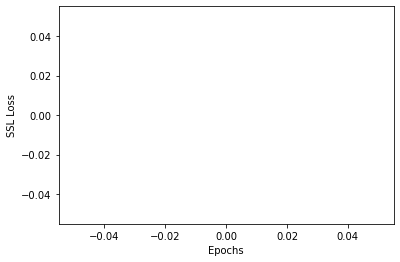

In [ ]:
progress_plot(data=hist_losses, x_lab="Epochs", y_lab="SSL Loss")

# **Representation Examination**

In [ ]:
class_count_dict = {
    "mnist": 10,
    "cifar10": 10,
    "cifar100": 100,
    "imagenet": 1000,
    "imagenette": 10,
    "imagewoof": 10,
    "svhn": 10,
    "stanford_cars": 196
}

In [ ]:
if check_clustering:
    # Representation Examination Parameters
    rep_model = "resnet18"
    rep_dataset = dataset_choice
    rep_model_path = origin_path_root + "_{}_{}_e{}.pth".format(rep_dataset, rep_model, rep_epoch)

    size = 10
    num_classes = class_count_dict[rep_dataset]

    n_trials = 1

    seed_list = [67, 97, 1024]

In [ ]:
if check_clustering:
    model = MoCo(base_encoder="resnet18", proj_dims=proj_dims)
    rep_model_dict, _, _, _, rep_losses, _ = load_checkpoint(rep_model_path)
    model.load_state_dict(rep_model_dict)
    model = model.encoder_q
    if parallel:
        model = nn.DataParallel(model)
    model.to(device)
    set_requires_grad(model, False)

In [ ]:
if check_clustering:
    rep_df = get_encodings(model, test_loader)
    temp_rep = np.asarray([value.astype("float64") for value in rep_df["rep"].values])
    tensor_rep = torch.tensor(temp_rep)
    print("Tensor representation dimensions:", tensor_rep.size())

    tensor_rep = torch.flatten(tensor_rep, start_dim=1)
    print("Representation dimensions:", tensor_rep.size()[-1])

    label_array = rep_df['lab']

Tensor representation dimensions: torch.Size([10000, 512])
Representation dimensions: 512


In [ ]:
if check_clustering:
    import umap
    import pacmap

    np_rep = np.asarray(tensor_rep)

    embs = []
    scatter_embs = []

    for i in range(n_trials):
        torch.manual_seed(seed_list[i])
        np.random.seed(seed_list[i])
        
        embeddings = umap.UMAP(
                              n_neighbors=50,
                              n_components=3,
                              min_dist=0.3,
                              densmap=True,
                              metric='cosine').fit_transform(tensor_rep)

        scatter_embeddings = embeddings.T

        embs.append(embeddings)
        scatter_embs.append(scatter_embeddings)
      
    draw_embs = umap.UMAP(
                        n_neighbors=50,
                        n_components=2,
                        min_dist=0.3,
                        densmap=True,
                        metric='cosine').fit_transform(tensor_rep)
                        
    draw_embs = draw_embs.T
    """

        embeddings = pacmap.PaCMAP(
                              n_neighbors=50,
                              n_components=3,
                              ).fit_transform(np_rep)
    
        scatter_embeddings = embeddings.T

        embs.append(embeddings)
        scatter_embs.append(scatter_embeddings)

    draw_embs = pacmap.PaCMAP(
                    n_neighbors=50,
                    n_components=2,
                    ).fit_transform(embs[-1]).T
    """

In [ ]:
if check_entropy:
    temp_tau = 10

    class Bin:
        def __init__(self, lower_bounds, upper_bounds):
            self.dim = len(lower_bounds)
            self.lower_bounds = lower_bounds
            self.upper_bounds = upper_bounds
            self.bin_count = 0

        def in_bin(self, item, add=True):
            in_bin = True
            for i in range(self.dim):
                if item[i] < self.lower_bounds[i] or item[i] >= self.upper_bounds[i]:
                    in_bin = False
            if in_bin and add:
                self.add_to_bin()
            return in_bin
        
        def add_to_bin(self):
            self.bin_count += 1

    def get_entropy(dist, eps=1e-8):
        return(-np.sum(np.multiply(dist, np.log(dist+eps))))

    def get_norm_entropy(dist):
        n = len(dist)
        uni_dist = np.asarray([1/n]*n)
        uni_entropy = get_entropy(uni_dist)
        return get_entropy(dist)/uni_entropy

    def bin_data(emb, sigma_factor=0.4, res_f=None):
        # only for low-dim
        dataset = emb
        bin_dims = []
        bins_len = 1
        bin_ranges = []
        
        dim = emb.shape[-1]

        abs_min, abs_max = [], []

        for i in range(dim):
            abs_min.append(np.min(emb.T[i]))
            abs_max.append(np.max(emb.T[i]))
        abs_min = np.asarray(abs_min)
        abs_max = np.asarray(abs_max)


        dist_mean = np.mean(emb, axis=0)
        dist_std = np.std(emb, axis=0)

        diff = abs_max-abs_min         
        if res_f:
            unit = [np.min(diff)/res_f]*dim
        else:
            unit = sigma_factor*dist_std
        for i in range(dim):
            bin_range = np.arange(abs_min[i], abs_max[i]+unit[i], unit[i])
            print("Dim {} bin count: {}".format(i, len(bin_range)-1))
            bin_ranges.append(bin_range)

        for bin_range in bin_ranges:
            bins_len *= len(bin_range)-1
            bin_dims.append(len(bin_range)-1)
        
        bins = np.empty(bins_len, dtype=object)
        bin_count = np.zeros(bins_len)

        for i in range(bins_len):
            coords = np.unravel_index(i, bin_dims)
            min = []
            max = []
            for j in range(len(coords)):
                min.append(bin_ranges[j][coords[j]])
                max.append(bin_ranges[j][coords[j]+1]) 
            
            bins[i] = Bin(lower_bounds=min, upper_bounds=max)
        
        for sample in emb:
            for bin in bins:
                sample_in_bin = bin.in_bin(sample)
                if sample_in_bin:
                    break

        for i in range(len(bins)):
            bin_count[i] = bins[i].bin_count
        
        print("Total binned data:", sum(bin_count)) 
        print("Total bins:", len(bins))
        print("Sanity check:", sum(bin_count/sum(bin_count)))
        return bin_count/sum(bin_count)

    avg_e = []
    #avg_ne = []
    for i in range(n_trials):
        dist = bin_data(embs[i])
        #dist = bin_data(embs[i], res_f=10)
        e = get_entropy(dist)
        #ne = get_norm_entropy(dist)
        print("\tTrial entropy:", e)
        #print("\tTrial normalized entropy:", ne)
        avg_e.append(e)
        #avg_ne.append(ne)
    print("Epoch examined:", rep_epoch)
    print("Entropy:", np.average(avg_e))
    #print("Normalized entropy:", np.average(avg_ne))

    del dist

Dim 0 bin count: 16
Dim 1 bin count: 18
Dim 2 bin count: 19
Total binned data: 10000.0
Total bins: 5472
Sanity check: 0.9999999999999948
	Trial entropy: 6.1025661985768895
Epoch examined: 60
Entropy: 6.1025661985768895


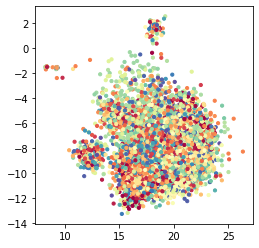

In [ ]:
if check_clustering:
    scatter_plot(name, draw_embs, label_array, size)

In [ ]:
if check_clustering: 
    from sklearn.cluster import KMeans

    n_factor_1 = 1
    n_factor_2 = 2
    base_cluster_label_array = []
    cluster_label_array = []

    for i in range(n_trials):
        means_clustering = KMeans(
            n_clusters=num_classes*n_factor_1, 
            init='k-means++',
            ).fit(embs[i])

        kmeans_labs = kmeans_clustering.labels_

        kmeans_clustering_alt = KMeans(
            n_clusters=int(num_classes*n_factor_2), 
            init='k-means++',
            ).fit(embs[i])

        kmeans_labs_alt = kmeans_clustering_alt.labels_

        base_cluster_label_array.append(kmeans_labs)
        cluster_label_array.append(kmeans_labs_alt)

In [ ]:
if check_clustering:
    from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

    s_score = []
    db_score = []
    ch_score = []
 
    for cluster_lab in base_cluster_label_array:
        s_score.append(silhouette_score(tensor_rep, cluster_lab))

        db_score.append(davies_bouldin_score(tensor_rep, cluster_lab))

        ch_score.append(calinski_harabasz_score(tensor_rep, cluster_lab))

    s_score_gt = silhouette_score(tensor_rep, label_array)
    db_score_gt = davies_bouldin_score(tensor_rep, label_array)
    ch_score_gt = calinski_harabasz_score(tensor_rep, label_array)


k-means clustering attempt 1...


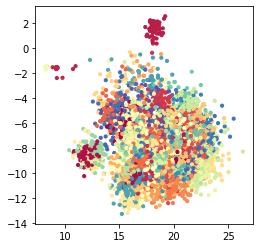

In [ ]:
if check_clustering: 
    print("k-means clustering attempt 1...")
    scatter_plot(name, draw_embs, base_cluster_label_array[-1], size)

k-means clustering attempt 2...


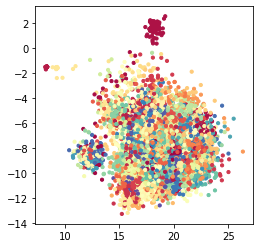

In [ ]:
if check_clustering:
    print("k-means clustering attempt 2...")
    scatter_plot(name, draw_embs, cluster_label_array[-1], size)

In [ ]:
if check_clustering:
    from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, normalized_mutual_info_score, v_measure_score
    tau = 0.3

    ami_list = []
    nmi_list = []
    ari_list = []
    v_score_list = []

    ami_compare_list = []
    ari_compare_list = []

    uni_scalar = []

    for i in range(n_trials):
        ami_list.append(adjusted_mutual_info_score(label_array, base_cluster_label_array[i]))
        nmi_list.append(normalized_mutual_info_score(label_array, base_cluster_label_array[i]))
        ari_list.append(adjusted_rand_score(label_array, base_cluster_label_array[i]))
        v_score_list.append(v_measure_score(label_array, base_cluster_label_array[i]))

        ami_cluster_compare = adjusted_mutual_info_score(cluster_label_array[i], base_cluster_label_array[i])
        ami_compare_list.append(ami_cluster_compare)

        ari_cluster_compare = adjusted_rand_score(cluster_label_array[i], base_cluster_label_array[i])
        ari_compare_list.append(ari_cluster_compare)

        avg_dist, avg_std = nn_avg_dist(embs[i])
        uni_scalar.append(avg_std/avg_dist)

    ami = np.average(ami_list)

    cv = 1-np.exp(-np.average(uni_scalar)/tau)

    nmi = np.average(nmi_list)
    ari = np.average(ari_list)
    v_score = np.average(v_score_list)

    avg_ami = np.average(ami_compare_list)
    std_ami = np.std(ami_compare_list)

    avg_ari = np.average(ari_compare_list)
    std_ari = np.std(ari_compare_list)

    print("SSL Loss:", rep_losses[-1])

    # Extrinsic measures
    print("\n")
    print("Extrinsic measures\n-----\n")
    print("Adjusted mutual information:", ami)
    print("Normalized mutual information:", nmi)
    print("Adjusted Rand index:", ari)
    print("V-score:", v_score)

    # Intrinsic measures
    print("\n")
    print("Intrinsic measures\n-----\n")
    print("Silhouette score:", np.average(s_score))
    print("Silhouette score (GT):", s_score_gt)

    print("Davies Bouldin score:", np.average(db_score))
    print("Davies Bouldin score (GT):", db_score_gt)

    print("Calinski Harabasz score:", np.average(ch_score))
    print("Calinski Harabasz score (GT):", ch_score_gt)

    print("\n")
    print("Clustering attempts comparison\n-----\n")
    print("CV Raw:", np.average(uni_scalar))
    print("Adjusted mutual information:", avg_ami)
    print("Adjusted mutual information (scaled):", cv*avg_ami)
    print("Adjusted mutual information standard deviation:", std_ami)
    print("Adjusted Rand index:", avg_ari)
    print("Adjusted Rand index standard deviation:", std_ari)

SSL Loss: 4.505162366886728


Extrinsic measures
-----

Adjusted mutual information: 0.11041597940124012
Normalized mutual information: 0.21567760769893599
Adjusted Rand index: 0.01826329385324798
V-score: 0.21567760769893599


Intrinsic measures
-----

Silhouette score: -0.025357892150991778
Silhouette score (GT): -0.07025061286440108
Davies Bouldin score: 4.540267933254056
Davies Bouldin score (GT): 8.255822640733866
Calinski Harabasz score: 54.134709818952246
Calinski Harabasz score (GT): 14.768462216737724


Clustering attempts comparison
-----

CV Raw: 0.7470431423543247
Adjusted mutual information: 0.7142925869126765
Adjusted mutual information (scaled): 0.6550791283791996
Adjusted mutual information standard deviation: 0.0
Adjusted Rand index: 0.38736621877759847
Adjusted Rand index standard deviation: 0.0


In [ ]:
if linear_probe:
    del embeddings
    del scatter_embeddings
    del embs
    del scatter_embs
    del model

# **Linear Probe**

In [ ]:
if linear_probe:
    class LinearProbeClassifier(nn.Module):

        def __init__(self, encoder, num_classes):
            super(LinearProbeClassifier, self).__init__()
            self.encoder = encoder
            set_requires_grad(self.encoder, False)

            prev_dim = get_output_shape(self.encoder)[1]
            
            self.classifier = nn.Sequential(
                nn.Linear(prev_dim, num_classes)
            )

        def forward(self, x):
            with torch.no_grad():
                r = self.encoder(x)
            c = self.classifier(r)
            return c

In [ ]:
if linear_probe:
    # Linear probe parameters and initializations
    sl_epochs = 20
    rep_model = "resnet18"
    rep_dataset = dataset_choice
    rep_model_path = origin_path_root + "_{}_{}_e{}.pth".format(rep_dataset, rep_model, rep_epoch)

    def train_sl_epoch(model, train_loader, criterion, optimizer, scheduler):
        epoch_loss = []
        epoch_acc = []

        # switch to train mode
        model.train()

        for i, (images, labs) in enumerate(train_loader):
            loss, acc = sl_batch_calc(model, criterion, images, labs)

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss.append(loss.item())
            epoch_acc.append(acc)

        model.eval()

        return np.average(epoch_loss), np.average(epoch_acc)

    def train_sl(model, train_loader, test_loader, sl_epochs, lr=0.08, weight_decay=1e-4, load=False, parallel=True):
        sl_losses = []
        sl_accs = []
        test_loss = []
        test_acc = []

        if parallel:
            checkpoint_path = "/content/gdrive/MyDrive/SSLLinProbes/checkpoint_{}.pth".format(model.module.encoder.arch)
        else:
            checkpoint_path = "/content/gdrive/MyDrive/SSLLinProbes/checkpoint_{}.pth".format(model.encoder.arch)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
                          model.parameters(), lr=lr, weight_decay=weight_decay
                      )
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=lr, total_steps=sl_epochs*int(len(train_loader)), pct_start=0.3)
        
        if load:
            model_dict, optimizer_dict, scheduler_dict, start_epoch, sl_losses, sl_accs = load_checkpoint(checkpoint_path)
            if parallel:
                model.module.load_state_dict(model_dict)
            else:
                model.load_state_dict(model_dict)
            optimizer.load_state_dict(optimizer_dict)
            scheduler.load_state_dict(scheduler_dict)

        else:
            start_epoch = 0

        for epoch in range(start_epoch, sl_epochs):
            print("Training SL Epoch {}/{}...".format(epoch+1, sl_epochs))
            sl_loss, sl_acc =  train_sl_epoch(model, train_loader, criterion, optimizer, scheduler)
            sl_losses.append(sl_loss)
            sl_accs.append(sl_acc)

            print(" SL Loss: {}".format(sl_losses[-1]))
            print(" SL Accuracy: {}".format(sl_accs[-1]))

            save_checkpoint(
                filepath=checkpoint_path, 
                curr_epoch=epoch+1, 
                model=model,
                losses=sl_losses, 
                acc=sl_accs, 
                optimizer=optimizer,
                scheduler=scheduler,
                parallel=parallel
                )

        model.eval()
        for i, (images, labs) in enumerate(test_loader):
            loss, acc = sl_batch_calc(model, criterion, images, labs)

            test_loss.append(loss.item())
            test_acc.append(acc)
            

        return sl_losses, sl_accs, np.average(test_loss), np.average(test_acc)

In [ ]:
if linear_probe:
    model = MoCo(base_encoder="resnet18", proj_dims=proj_dims)
    rep_model_dict, _, _, _, rep_losses, _ = load_checkpoint(rep_model_path)
    model.load_state_dict(rep_model_dict)
    model = model.encoder_q
    model = LinearProbeClassifier(encoder=model, num_classes=class_count_dict[rep_dataset])
    if parallel:
        model = nn.DataParallel(model)
    model.to(device)

In [ ]:
if linear_probe:
    sl_losses, sl_accs, test_loss, test_acc, = train_sl(model, train_loader=lp_loader, test_loader=test_loader, sl_epochs=sl_epochs, load=False, parallel=parallel)

In [ ]:
if linear_probe:
    progress_plot(data=sl_losses, x_lab="Epochs", y_lab="SL Loss")
    print(test_loss)

In [ ]:
if linear_probe:
    progress_plot(data=sl_accs, x_lab="Epochs", y_lab="SL Accuracy")
    print(test_acc)